In [1]:
import mbe_automation

/home/marcin/.virtualenvs/laptop-env/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


# Glance inside your HDF5 dataset
`tree` displays the tree structure of your dataset file. Each end node in the tree structure corresponds to a numpy array with some shape (rank) and datatype (dtype). You can read those data using specialized functions from `mbe_automation.storage`.

A dataset path is composed of three types of segments, e.g.,

`workflow/system/property`

where

* `workflow` is the general computational task (may include subtasks) from which the data originate.
* `system` is the label of a physical system (crystal or molecule) computed with a set of conditions specified in the square brackets. For example, a computation of a crystal at a series of temperatures produces a series of labels with each temperature specified in the square brackets. 
* `property` is a data structure corresponding to some physical aspect of the system, e.g., `structure` and `force_constants`.

In [3]:
mbe_automation.storage.tree("./training_set.hdf5")

training_set.hdf5
└── training
    ├── md_sampling
    │   └── crystal[dyn:T=298.15,p=0.00010]
    │       ├── finite_subsystems
    │       │   ├── n=1
    │       │   │   ├── @attrs
    │       │   │   │   └── n_molecules: 1
    │       │   │   ├── cluster_of_molecules
    │       │   │   │   ├── @attrs
    │       │   │   │   │   ├── n_atoms: 16
    │       │   │   │   │   ├── n_frames: 1001
    │       │   │   │   │   └── periodic: False
    │       │   │   │   ├── E_pot (eV∕atom) [shape=(1001,), dtype=float64]
    │       │   │   │   ├── atomic_numbers [shape=(16,), dtype=int64]
    │       │   │   │   ├── feature_vectors [shape=(1001, 16, 256), dtype=float64]
    │       │   │   │   ├── forces (eV∕Å) [shape=(1001, 16, 3), dtype=float64]
    │       │   │   │   ├── masses (u) [shape=(16,), dtype=float64]
    │       │   │   │   └── positions (Å) [shape=(1001, 16, 3), dtype=float64]
    │       │   │   └── molecule_indices [shape=(1,), dtype=int64]
    │       │   ├── n=2
    │    

# Read trajectory from the NPT simulation of the periodic system

In [4]:
trajectory_pbc = mbe_automation.storage.read_trajectory(
    dataset="./training_set.hdf5",
    key="training/md_sampling/crystal[dyn:T=298.15,p=0.00010]/trajectory"
    )

print(f"There are {trajectory_pbc.n_frames} in the PBC trajectory")

There are 1001 in the PBC trajectory


In [5]:
trajectory_pbc_subsampled = trajectory_pbc.subsample(n=100)

ValueError: subsample requires the Trajectory to have feature_vectors.

# Convert trajectory from mbe_automation.storage.Structure to ASE trajectory object

In [6]:
ase_trajectory_pbc = mbe_automation.storage.ASETrajectory(trajectory_pbc)

# Access selected frame from PBC trajectroy as an ASE Atoms instance

In [7]:
ase_trajectory_pbc[10]

Atoms(symbols='C132H176O44', pbc=True, cell=[[6.454441390266101, 12.247285847011245, -6.444002037495458], [-12.885036090405942, 5.405081489743934, -6.602821510650227], [-0.005711919506058777, 14.939546779926468, 6.96319448271102]], masses=...)

# Visualize PBC trajectory

In [8]:
mbe_automation.structure.display.to_chemiscope(structure=trajectory_pbc)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 352, 'names': ['H', 'H', 'H', 'H', 'H', 'H', 'H', '…

# Read finite subsystem trajectory extracted from PBC NPT simulation

In [9]:
finite_subsystem_npt = mbe_automation.storage.read_finite_subsystem(
    dataset="training_set.hdf5",
    key="training/md_sampling/crystal[dyn:T=298.15,p=0.00010]/finite_subsystems/n=8"
)
print(f"number of molecules: {finite_subsystem_npt.n_molecules}")
print(f"number of frames: {finite_subsystem_npt.cluster_of_molecules.n_frames}")

number of molecules: 8
number of frames: 1001


Subsampled 20 frames using 'farthest_point_sampling'.


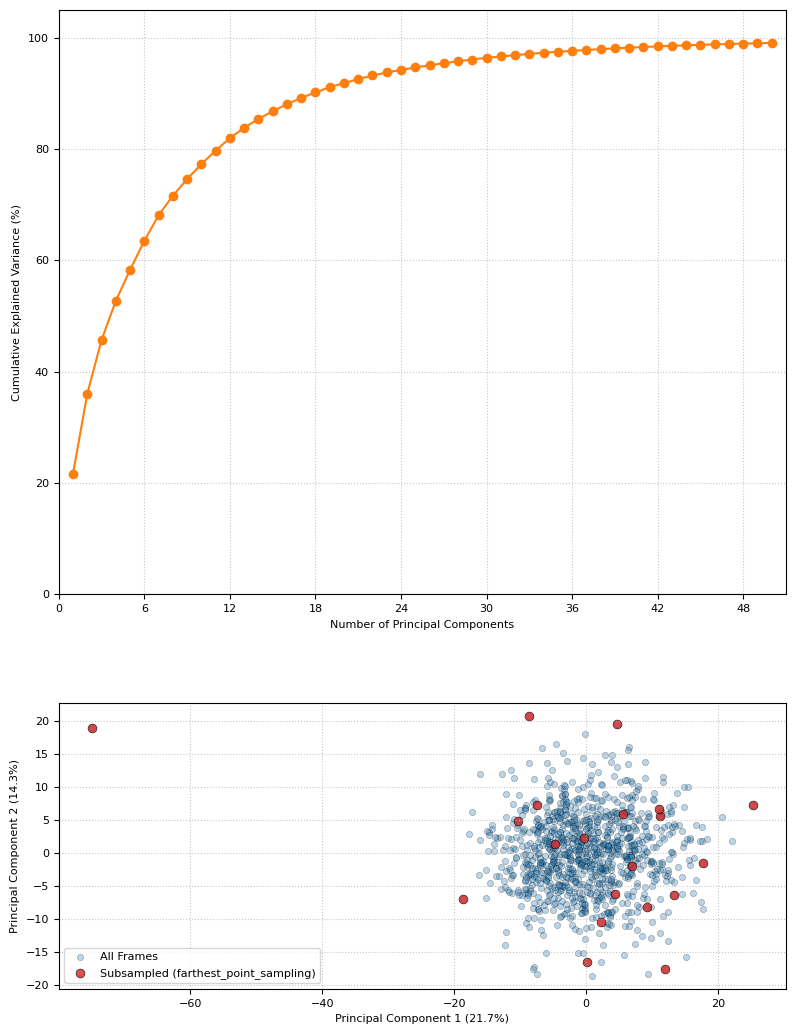

In [10]:
mbe_automation.ml.display.pca(
    finite_subsystem_npt.cluster_of_molecules,
    plot_type="2d",
    subset_size = 20,
    subsample_algorithm="farthest_point_sampling"
)

In [11]:
mbe_automation.ml.display.to_chemiscope(finite_subsystem_npt.cluster_of_molecules)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 128, 'names': ['H', 'H', 'C', 'C', 'H', 'H', 'H', '…

# Create a subset of frames of the finite subsystem using farthest point sampling

In [17]:
subsampled = finite_subsystem_npt.subsample(n=10, algorithm="farthest_point_sampling")
print(f"subsampled cluster has {subsampled.cluster_of_molecules.n_frames} frames")

subsampled cluster has 10 frames


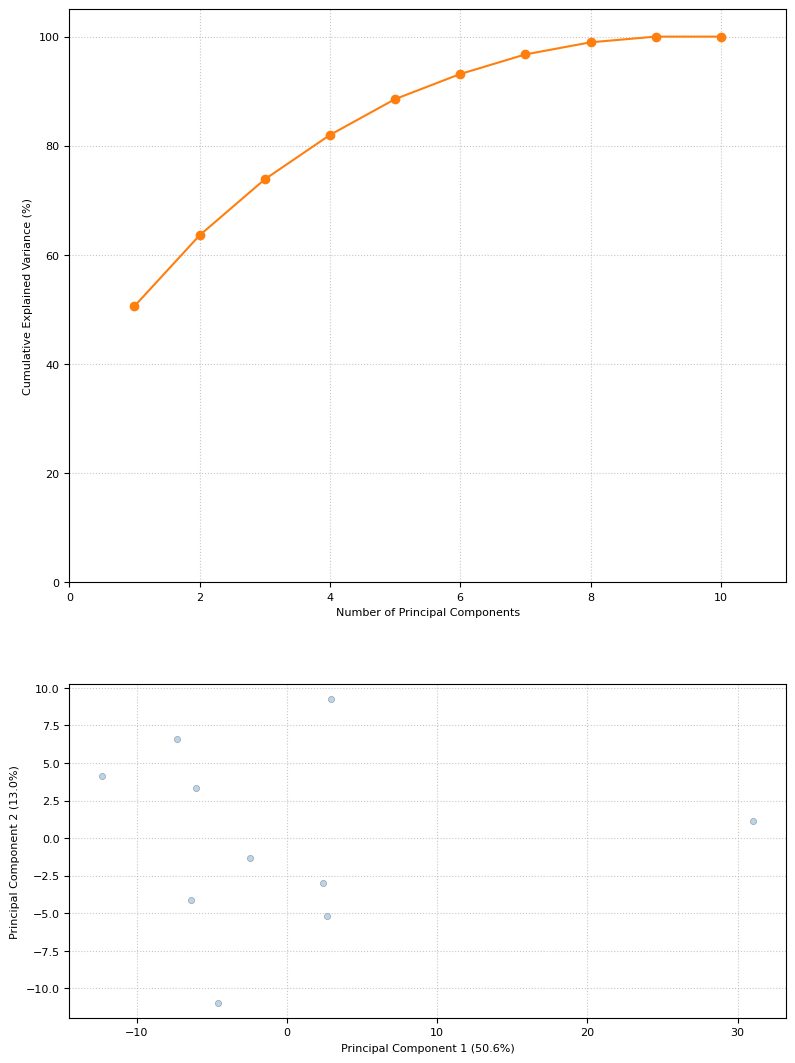

In [18]:
mbe_automation.ml.display.pca(subsampled.cluster_of_molecules)

# Visualize finite subsystem extracted from PBC NPT simulation

In [19]:
mbe_automation.structure.display.to_chemiscope(structure=finite_subsystem_npt.cluster_of_molecules)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 128, 'names': ['H', 'H', 'C', 'C', 'H', 'H', 'H', '…

# Read the subsystem part of the MD trajectory

In [20]:
finite_subsystem = mbe_automation.storage.read_finite_subsystem(
    dataset="./training_set.hdf5",
    key="training/phonon_sampling/finite_subsystems/n=4"
    )

In [21]:
mbe_automation.structure.display.to_chemiscope(finite_subsystem.cluster_of_molecules)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 64, 'names': ['C', 'H', 'C', 'H', 'H', 'C', 'H', 'O…

# Read PBC trajectory generated with PhononSampling workflow

In [22]:
molecular_crystal_phonons = mbe_automation.storage.read_molecular_crystal(
    dataset="training_set_08.hdf5",
    key="training/phonon_sampling/molecular_crystal"
)
print(f"number of molecules {molecular_crystal_phonons.n_molecules}")
print(f"number of frames {molecular_crystal_phonons.supercell.n_frames}")

number of molecules 144
number of frames 20


# Visualize PBC trajectory generated with PhononSampling

Note that in `molecular_crystal` objects, atoms belonging to the same molecule are contiguous in space.

In [23]:
mbe_automation.structure.display.to_chemiscope(molecular_crystal_phonons.supercell)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 720, 'names': ['H', 'H', 'H', 'H', 'H', 'H', 'H', '…

# Read a finite subsystem extracted from PBC PhononSampling trajectory

In [24]:
finite_subsystem_phonons = mbe_automation.storage.read_finite_subsystem(
    dataset="training_set.hdf5",
    key="training/phonon_sampling/finite_subsystems/n=4"
)

# Visualize finite subsytem extracted from PBC PhononSampling trajectory

In [25]:
mbe_automation.structure.display.to_chemiscope(finite_subsystem_phonons.cluster_of_molecules)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 64, 'names': ['C', 'H', 'C', 'H', 'H', 'C', 'H', 'O…

In [ ]:
mbe_automation.ml.display.pca(finite_subsystem_phonons.cluster_of_molecules)

In [26]:
mbe_automation.ml.display.to_chemiscope(finite_subsystem_phonons.cluster_of_molecules)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 64, 'names': ['C', 'H', 'C', 'H', 'H', 'C', 'H', 'O…

# Save selected frames to xyz files

In [27]:
mbe_automation.storage.to_xyz_file(save_path="04.xyz", system=trajectory_pbc, frame_index=4)

In [28]:
mbe_automation.storage.to_xyz_file(save_path="04_pbc.cif", system=trajectory_pbc, frame_index=4)

In [29]:
mbe_automation.storage.to_xyz_file(
    system=finite_subsystem_phonons.cluster_of_molecules, 
    save_path="frame_04_phonons_supercell.xyz",
    frame_index=4
)